In [1]:
import copy
import torch
import argparse
import numpy as np
import umap
from torchvision import datasets, transforms
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, f1_score, roc_auc_score, roc_curve, matthews_corrcoef as mcc
from torch.utils.data import Subset
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans

import numbers
import torch.nn as nn
from cac import batch_cac
from autoencoder import AutoEncoder
from sklearn.metrics import davies_bouldin_score as dbs, adjusted_rand_score as ari
from matplotlib import pyplot as plt
color = ['grey', 'red', 'blue', 'pink', 'brown', 'black', 'magenta', 'purple', 'orange', 'cyan', 'olive']

In [2]:
def get_dataset(DATASET, base_dir):
    if DATASET == "cic":
        Xa = pd.read_csv(base_dir + "/CIC/cic_set_a.csv")
        Xb = pd.read_csv(base_dir + "/CIC/cic_set_b.csv")
        Xc = pd.read_csv(base_dir + "/CIC/cic_set_c.csv")

        ya = Xa['In-hospital_death']
        yb = Xb['In-hospital_death']
        yc = Xc['In-hospital_death']

        Xa = Xa.drop(columns=['recordid', 'Survival', 'In-hospital_death'])
        Xb = Xb.drop(columns=['recordid', 'Survival', 'In-hospital_death'])
        Xc = Xc.drop(columns=['recordid', 'Survival', 'In-hospital_death'])

        cols = Xa.columns

        scale = StandardScaler()
        Xa = scale.fit_transform(Xa)
        Xb = scale.fit_transform(Xb)
        Xc = scale.fit_transform(Xc)

        Xa = pd.DataFrame(Xa, columns=cols)
        Xb = pd.DataFrame(Xb, columns=cols)
        Xc = pd.DataFrame(Xc, columns=cols)

        Xa = Xa.fillna(0)
        Xb = Xb.fillna(0)
        Xc = Xc.fillna(0)

        X_train = pd.concat([Xa, Xb])
        y_train = pd.concat([ya, yb])

        X_test = Xc
        y_test = yc

        X = pd.concat([X_train, X_test]).to_numpy()
        y = pd.concat([y_train, y_test]).to_numpy()

    elif DATASET == "titanic":
        X_train = pd.read_csv(base_dir + "/" + DATASET + "/" + "X_train.csv").to_numpy()
        X_test = pd.read_csv(base_dir + "/" + DATASET + "/" + "X_test.csv").to_numpy()
        y_train = pd.read_csv(base_dir + "/" + DATASET + "/" + "y_train.csv").to_numpy()
        y_test = pd.read_csv(base_dir + "/" + DATASET + "/" + "y_test.csv").to_numpy()

        X = np.vstack([X_train, X_test])
        y = np.vstack([y_train, y_test])
        y1 = []
        for i in range(len(y)):
            y1.append(y[i][0])
        y = np.array(y1)
        # X = pd.concat([X_train, X_test]).to_numpy()
        # y = pd.concat([y_train, y_test]).to_numpy()

    else:
        X = pd.read_csv(base_dir + "/" + DATASET + "/" + "X.csv").to_numpy()
        y = pd.read_csv(base_dir + "/" + DATASET + "/" + "y.csv").to_numpy()
        y1 = []
        for i in range(len(y)):
            y1.append(y[i][0])
        y = np.array(y1)
    return X, y

In [3]:
color = ['grey', 'red', 'blue', 'pink', 'brown', 'black', 'magenta', 'purple', 'orange', 'cyan', 'olive']

import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

class NNClassifier(nn.Module):
    def __init__(self, args):
        super(NNClassifier, self).__init__()
        self.args = args
        self.input_dim = args.input_dim
        self.output_dim = self.input_dim
        self.n_classes = args.n_classes

        self.encoder = nn.Sequential(
            nn.Linear(args.input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )

        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, args.input_dim)
        )

        self.classifier = nn.Sequential(
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, args.n_classes)
        )
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs, output="latent"):
        x = self.encoder(inputs)
        if output == "latent":
            return x
        else:
            return self.decoder(x), self.classifier(x)

In [4]:
def evaluate(model, test_loader):
    X_test = []
    y_test = []
    y_pred = []
    y_classifier_pred = []
    y_classifier_pred_proba = []

    for data, target in test_loader:
        batch_size = data.size()[0]
        X_test.append(data)
        data = data.view(batch_size, -1).to(model.device)
        
        with torch.no_grad():
            latent_X = model.autoencoder(data, latent=True)
            latent_X = latent_X.detach().to(model.device).numpy()

        y_test.append(target.view(-1, 1).numpy())
    
    X_test = torch.vstack(X_test)
    latent_X = model.autoencoder(X_test, latent=True)
    X_test = latent_X.detach().to(model.device).numpy()
    y_test = np.vstack(y_test).reshape(-1)
    y_pred = model.clustering.update_assign(X_test, target).reshape(-1)
    nmi, ari = normalized_mutual_info_score(y_test, y_pred), adjusted_rand_score(y_test, y_pred)

    if model.clustering == "cac":
        base_f1 = f1_score(y_test, model.base_classifier[-1].predict(X_test))
        base_mcc = mcc(y_test, model.base_classifier[-1].predict(X_test))
        base_auc = roc_auc_score(y_test, model.base_classifier[-1].predict_proba(X_test)[:,1])

        X_cluster_test = []
        y_cluster_test = []

        for j in range(model.args.n_clusters):
            cluster_index = np.where(y_pred == j)[0]
            X_cluster = X_test[cluster_index]
            y_cluster = y_test[cluster_index]

            X_cluster_test.append(X_cluster)
            y_cluster_test.extend(y_cluster)

            # Select the cluster classifiers appearing in the latest iteration
            y_classifier_pred.extend(model.cluster_classifiers[-1][j].predict(X_cluster))
            y_classifier_pred_proba.extend(model.cluster_classifiers[-1][j].predict_proba(X_cluster)[:,1])

        cac_f1 = f1_score(y_cluster_test, y_classifier_pred)
        cac_mcc = mcc(y_cluster_test, y_classifier_pred)
        cac_auc = roc_auc_score(y_test, y_classifier_pred_proba)

        return (nmi, ari, base_f1, base_mcc, base_auc, cac_f1, cac_mcc, cac_auc)
    else:
        return (nmi, ari)
    
def solver(args, model, X_train, train_loader, test_loader):
    rec_loss_list = model.pretrain(train_loader, epoch=args.pre_epoch)
    nmi_list = []
    ari_list = []

    for e in range(args.epoch):
        model.train()
        model.fit(e, train_loader)
        
        model.eval()
        out = evaluate(model, test_loader)  # evaluation on the test_loader
        if len(out) > 2:
            NMI, ARI, base_f1, base_mcc, base_auc, cac_f1, cac_mcc, cac_auc = out
            print('Epoch: {:02d} | NMI: {:.3f} | ARI: {:.3f} | Base_F1: {:.3f} | Base_MCC: {:.3f} | Base_AUC: {:.3f} | CAC_F1: {:.3f} | CAC_MCC: {:.3f} | CAC_AUC: {:.3f}'.format(
                e+1, NMI, ARI, base_f1, base_mcc, base_auc, cac_f1, cac_mcc, cac_auc))
        else:
            NMI, ARI = out
            print('Epoch: {:02d} | NMI: {:.3f} | ARI: {:.3f}'.format(e+1, NMI, ARI))

        nmi_list.append(NMI)
        ari_list.append(ARI)
        
        
    return rec_loss_list, nmi_list, ari_list

def create_imbalanced_data_clusters(n_samples=1000, n_features=8, n_informative=5, n_classes=2,\
                            n_clusters = 2, frac=0.4, outer_class_sep=0.5, inner_class_sep=0.2, clus_per_class=2, seed=0):
    np.random.seed(seed)
    X = np.empty(shape=n_features)
    Y = np.empty(shape=1)
    offsets = np.random.normal(0, outer_class_sep, size=(n_clusters, n_features))
    for i in range(n_clusters):
        samples = int(np.random.normal(n_samples, n_samples/10))
        x, y = make_classification(n_samples=samples, n_features=n_features, n_informative=n_informative,\
                                    n_classes=n_classes, class_sep=inner_class_sep, n_clusters_per_class=clus_per_class)
                                    # n_repeated=0, n_redundant=0)
        x += offsets[i]
        y_0 = np.where(y == 0)[0]
        y_1 = np.where(y != 0)[0]
        y_1 = np.random.choice(y_1, int(np.random.normal(frac, frac/4)*len(y_1)))
        index = np.hstack([y_0,y_1])
        np.random.shuffle(index)
        x_new = x[index]
        y_new = y[index]

        X = np.vstack((X,x_new))
        Y = np.hstack((Y,y_new))

    X = pd.DataFrame(X[1:,:])
    Y = Y[1:]
    return X, np.array(Y).astype('int')


In [40]:
# Dataset parameters
params = {
'dir' : 'synthetic',
'dataset' : 'synthetic',

# Training parameters
'lr' : 0.002,
'alpha' : 0,
'wd' : 5e-4,
'batch_size' : 1024,
'epoch' : 15,
'pre_epoch' : 20,
'pretrain' : True,
"load_ae": False,
"classifier": "LR",

# Model parameters
'lamda' : 0.005,
'beta' : 0.00001,
'hidden_dims' : [500, 500, 2000],
'latent_dim' : 20,
'n_clusters' : 2,
'clustering' : 'cac',
'n_classes'  : 2,

# Utility parameters
'n_jobs' : 6,
'device' : 'cpu',
'log_interval' : 10}

class parameters(object):
    def __init__(self, params):
        self.dir = params['dir']
        self.input_dim = -1
        self.dataset = params['dataset']
        
        # Training parameters
        self.lr = params['lr']
        self.alpha = params['alpha']
        self.wd = params['wd']
        self.batch_size = params['batch_size']
        self.epoch = params['epoch']
        self.pre_epoch = params['pre_epoch']
        self.pretrain = params['pretrain']
        self.load_ae = params['load_ae']
        self.classifier = params['classifier']

        # Model parameters
        self.lamda = params['lamda']
        self.beta = params['beta']
        self.hidden_dims = params['hidden_dims']
        self.latent_dim = params['latent_dim']
        self.n_clusters = params['n_clusters']
        self.clustering = params['clustering']
        self.n_classes = params['n_classes']

        # Utility parameters
        self.n_jobs = params['n_jobs']
        self.device = params['device']
        self.log_interval = params['log_interval']

args = parameters(params)
datasets = ['titanic', 'magic', 'creditcard', 'adult', 'diabetes', 'cic', 'sepsis', 'synthetic', 'new_synthetic']

In [41]:
if args.dataset in datasets:
    base_dir = "../../CAC_code/data"
    print("Loading Dataset:", args.dataset)
    if args.dataset == "synthetic":
        n_feat = 45
        X, y = create_imbalanced_data_clusters(n_samples=5000,\
               n_clusters=args.n_clusters, n_features = n_feat,\
               inner_class_sep=0.2, outer_class_sep=2, seed=0)
        args.input_dim = n_feat

    elif args.dataset == "paper_synthetic":
        n_feat = 100
        X, y = paper_synthetic(10000)
        X = pd.DataFrame(X)
        y = pd.DataFrame(y)
        args.input_dim = n_feat

    else:
        X, y = get_dataset(args.dataset, base_dir)
        args.input_dim = X.shape[1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)
    X_train_data_loader = list(zip(X_train.astype(np.float32), y_train))
    X_test_data_loader  = list(zip(X_test.astype(np.float32), y_test))
    
    train_loader = torch.utils.data.DataLoader(X_train_data_loader,
        batch_size=args.batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(X_test_data_loader, 
        batch_size=args.batch_size, shuffle=False)

elif args.dir == "../datasets/mnist":
    # Load data
    transformer = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,),
                                                           (0.3081,))])

    train_set = datasets.MNIST(args.dir, train=True, download=True, transform=transformer)
    test_set  = datasets.MNIST(args.dir, train=False, transform=transformer)
    train_limit = list(range(0, len(train_set))) if not args.test_run else list(range(0, 500))    
    test_limit  = list(range(0, len(test_set)))  if not args.test_run else list(range(0, 500))    

    train_loader = torch.utils.data.DataLoader(Subset(train_set, train_limit),
        batch_size=args.batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(Subset(test_set, test_limit), 
        batch_size=args.batch_size, shuffle=False)

Loading Dataset: synthetic


## Direct Classification

In [42]:
model = NNClassifier(args)
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss(reduction='mean')
criterion_rec = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

In [43]:
model.train()
device = "cpu"
EPOCHS = 90
for e in range(1, EPOCHS):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        X_inp = (X_batch + np.random.normal(0, 0.01, size=X_batch.shape)).clone().detach().float()
        X_rec, y_pred = model(X_inp, output="decoded")
        acc = f1_score(np.argmax(y_pred.detach().numpy(), axis=1), y_batch.unsqueeze(1))

        loss_rec = criterion_rec(X_batch, X_rec)
        loss_rec.backward()
        optimizer.step()
        
        epoch_loss += loss_rec.item()
        epoch_acc += acc.item()
        
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.99652 | Acc: 0.000
Epoch 002: | Loss: 0.92313 | Acc: 0.000
Epoch 003: | Loss: 0.70635 | Acc: 0.000
Epoch 004: | Loss: 0.56790 | Acc: 0.000
Epoch 005: | Loss: 0.51576 | Acc: 0.000
Epoch 006: | Loss: 0.51509 | Acc: 0.000
Epoch 007: | Loss: 0.50751 | Acc: 0.000
Epoch 008: | Loss: 0.50180 | Acc: 0.000
Epoch 009: | Loss: 0.49940 | Acc: 0.000
Epoch 010: | Loss: 0.49812 | Acc: 0.000
Epoch 011: | Loss: 0.49773 | Acc: 0.000
Epoch 012: | Loss: 0.49738 | Acc: 0.000
Epoch 013: | Loss: 0.49407 | Acc: 0.000
Epoch 014: | Loss: 0.49271 | Acc: 0.000
Epoch 015: | Loss: 0.49251 | Acc: 0.000
Epoch 016: | Loss: 0.48405 | Acc: 0.000
Epoch 017: | Loss: 0.48117 | Acc: 0.000
Epoch 018: | Loss: 0.47999 | Acc: 0.000
Epoch 019: | Loss: 0.47692 | Acc: 0.000
Epoch 020: | Loss: 0.47345 | Acc: 0.000
Epoch 021: | Loss: 0.47141 | Acc: 0.000
Epoch 022: | Loss: 0.46224 | Acc: 0.000
Epoch 023: | Loss: 0.45505 | Acc: 0.000
Epoch 024: | Loss: 0.45197 | Acc: 0.000
Epoch 025: | Loss: 0.44417 | Acc: 0.000


In [44]:
model.train()
device = "cpu"
EPOCHS = 100
for e in range(1, EPOCHS):
    epoch_loss = 0
    epoch_acc = 0
    alpha = (1-e/EPOCHS)
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        X1, y_pred = model(X_batch, output="decoded")
        X_latent = model(X_batch)
        loss = torch.tensor(0.).to(device)
        loss_rec = torch.tensor(0.).to(device)
        km = KMeans(n_clusters = args.n_clusters)
        clusters = km.fit_predict(X_latent.detach().numpy())

#         for j in range(args.n_clusters):
#             idx = np.where(clusters == j)[0]
#             X_idx = X_latent[idx]
#             y_pred_idx = y_pred[idx]
#             y_batch_idx = y_batch[idx]
#             loss += criterion(y_pred_idx, y_batch_idx)

        loss = criterion(y_pred, y_batch)
#         loss_rec = 0.3*criterion_rec(X_batch, X1)
        acc = f1_score(np.argmax(y_pred.detach().numpy(), axis=1), y_batch.unsqueeze(1))
#         loss_rec.backward(retain_graph=True)
        loss.backward()
        optimizer.step()
        epoch_loss += (loss+loss_rec).item()
        epoch_acc += acc.item()

    X1, y_pred = model(torch.tensor(X_test).to(device).float(), output="decoded")
    test_f1 = f1_score(np.argmax(y_pred.detach().numpy(), axis=1), y_test)
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f} | Test Acc: {test_f1:.3f}')

Epoch 001: | Loss: 0.62525 | Acc: 0.000 | Test Acc: 0.000
Epoch 002: | Loss: 0.61423 | Acc: 0.000 | Test Acc: 0.000
Epoch 003: | Loss: 0.61118 | Acc: 0.000 | Test Acc: 0.000
Epoch 004: | Loss: 0.61341 | Acc: 0.000 | Test Acc: 0.000
Epoch 005: | Loss: 0.59250 | Acc: 0.000 | Test Acc: 0.000
Epoch 006: | Loss: 0.59698 | Acc: 0.000 | Test Acc: 0.000
Epoch 007: | Loss: 0.59829 | Acc: 0.000 | Test Acc: 0.000
Epoch 008: | Loss: 0.59533 | Acc: 0.000 | Test Acc: 0.000
Epoch 009: | Loss: 0.60315 | Acc: 0.000 | Test Acc: 0.000
Epoch 010: | Loss: 0.59206 | Acc: 0.000 | Test Acc: 0.000
Epoch 011: | Loss: 0.59930 | Acc: 0.000 | Test Acc: 0.000
Epoch 012: | Loss: 0.59272 | Acc: 0.000 | Test Acc: 0.000
Epoch 013: | Loss: 0.58640 | Acc: 0.000 | Test Acc: 0.000
Epoch 014: | Loss: 0.59151 | Acc: 0.000 | Test Acc: 0.000
Epoch 015: | Loss: 0.59021 | Acc: 0.000 | Test Acc: 0.000
Epoch 016: | Loss: 0.59281 | Acc: 0.000 | Test Acc: 0.000
Epoch 017: | Loss: 0.58574 | Acc: 0.000 | Test Acc: 0.000
Epoch 018: | L

In [45]:
reducer = umap.UMAP()
X_train = X_train.astype(float)
x_emb_train = reducer.fit_transform(model(torch.tensor(X_train).float().to(device)).detach().numpy())
x_emb_test = reducer.transform(model(torch.tensor(X_test).float().to(device)).detach().numpy())

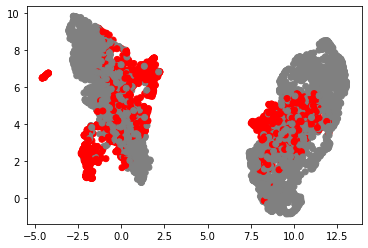

In [46]:
c_clusters = [color[int(y_train[i])] for i in range(len(y_train))]
plt.scatter(x_emb_train[:,0], x_emb_train[:,1], color=c_clusters)

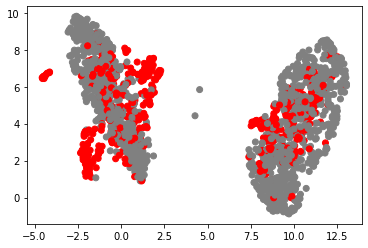

In [47]:
c_clusters = [color[int(y_test[i])] for i in range(len(y_test))]
plt.scatter(x_emb_test[:,0], x_emb_test[:,1], color=c_clusters)

In [48]:
X1, y_pred = model(torch.tensor(X_test).to(device).float(), output="decoded")
print("Test F1")
print(f1_score(np.argmax(y_pred.detach().numpy(), axis=1), y_test))

Test F1
0.6339285714285715


## Cluster-then-predict

In [49]:
model = NNClassifier(args)
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss(reduction='mean')
criterion_rec = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

In [50]:
model.train()
device = "cpu"
EPOCHS = 90
for e in range(1, EPOCHS):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        X_inp = (X_batch + np.random.normal(0, 0.01, size=X_batch.shape)).clone().detach().float()
        X_rec, y_pred = model(X_inp, output="decoded")
        acc = f1_score(np.argmax(y_pred.detach().numpy(), axis=1), y_batch.unsqueeze(1))

        loss_rec = criterion_rec(X_batch, X_rec)
        loss_rec.backward()
        optimizer.step()
        
        epoch_loss += loss_rec.item()
        epoch_acc += acc.item()
        
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.99585 | Acc: 0.456
Epoch 002: | Loss: 0.93251 | Acc: 0.456
Epoch 003: | Loss: 0.75251 | Acc: 0.447
Epoch 004: | Loss: 0.58604 | Acc: 0.448
Epoch 005: | Loss: 0.52257 | Acc: 0.452
Epoch 006: | Loss: 0.51362 | Acc: 0.437
Epoch 007: | Loss: 0.50851 | Acc: 0.449
Epoch 008: | Loss: 0.50170 | Acc: 0.446
Epoch 009: | Loss: 0.50279 | Acc: 0.452
Epoch 010: | Loss: 0.49917 | Acc: 0.448
Epoch 011: | Loss: 0.49982 | Acc: 0.446
Epoch 012: | Loss: 0.49802 | Acc: 0.455
Epoch 013: | Loss: 0.49480 | Acc: 0.446
Epoch 014: | Loss: 0.49529 | Acc: 0.450
Epoch 015: | Loss: 0.49740 | Acc: 0.461
Epoch 016: | Loss: 0.49436 | Acc: 0.453
Epoch 017: | Loss: 0.48998 | Acc: 0.448
Epoch 018: | Loss: 0.48319 | Acc: 0.454
Epoch 019: | Loss: 0.47665 | Acc: 0.452
Epoch 020: | Loss: 0.46877 | Acc: 0.448
Epoch 021: | Loss: 0.46462 | Acc: 0.451
Epoch 022: | Loss: 0.45857 | Acc: 0.458
Epoch 023: | Loss: 0.45771 | Acc: 0.449
Epoch 024: | Loss: 0.45185 | Acc: 0.445
Epoch 025: | Loss: 0.45278 | Acc: 0.456


In [51]:
model.train()
device = "cpu"
EPOCHS = 100
for e in range(1, EPOCHS):
    epoch_loss = 0
    epoch_acc = 0
    alpha = (1-e/EPOCHS)
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        X1, y_pred = model(X_batch, output="decoded")
        X_latent = model(X_batch)
        loss = torch.tensor(0.).to(device)
        loss_rec = torch.tensor(0.).to(device)
        km = KMeans(n_clusters = args.n_clusters)
        clusters = km.fit_predict(X_latent.detach().numpy())

        for j in range(args.n_clusters):
            idx = np.where(clusters == j)[0]
            X_idx = X_latent[idx]
            y_pred_idx = y_pred[idx]
            y_batch_idx = y_batch[idx]
            loss += criterion(y_pred_idx, y_batch_idx)

        loss = criterion(y_pred, y_batch)
        loss_rec = 0.25*criterion_rec(X_batch, X1)
        acc = f1_score(np.argmax(y_pred.detach().numpy(), axis=1), y_batch.unsqueeze(1))
        loss_rec.backward(retain_graph=True)
        loss.backward()
        optimizer.step()
        epoch_loss += (loss+loss_rec).item()
        epoch_acc += acc.item()

    X1, y_pred = model(torch.tensor(X_test).to(device).float(), output="decoded")
    test_f1 = f1_score(np.argmax(y_pred.detach().numpy(), axis=1), y_test)
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f} | Test Acc: {test_f1:.3f}')

Epoch 001: | Loss: 0.73272 | Acc: 0.171 | Test Acc: 0.000
Epoch 002: | Loss: 0.68741 | Acc: 0.000 | Test Acc: 0.000
Epoch 003: | Loss: 0.68123 | Acc: 0.000 | Test Acc: 0.004
Epoch 004: | Loss: 0.67542 | Acc: 0.001 | Test Acc: 0.000
Epoch 005: | Loss: 0.66752 | Acc: 0.000 | Test Acc: 0.000
Epoch 006: | Loss: 0.66595 | Acc: 0.000 | Test Acc: 0.000
Epoch 007: | Loss: 0.66332 | Acc: 0.000 | Test Acc: 0.000
Epoch 008: | Loss: 0.65730 | Acc: 0.000 | Test Acc: 0.000
Epoch 009: | Loss: 0.65087 | Acc: 0.000 | Test Acc: 0.000
Epoch 010: | Loss: 0.66682 | Acc: 0.000 | Test Acc: 0.000
Epoch 011: | Loss: 0.65678 | Acc: 0.000 | Test Acc: 0.000
Epoch 012: | Loss: 0.66856 | Acc: 0.000 | Test Acc: 0.000
Epoch 013: | Loss: 0.65590 | Acc: 0.000 | Test Acc: 0.000
Epoch 014: | Loss: 0.65554 | Acc: 0.000 | Test Acc: 0.000
Epoch 015: | Loss: 0.65025 | Acc: 0.000 | Test Acc: 0.000
Epoch 016: | Loss: 0.65883 | Acc: 0.001 | Test Acc: 0.000
Epoch 017: | Loss: 0.65009 | Acc: 0.002 | Test Acc: 0.000
Epoch 018: | L

In [52]:
reducer = umap.UMAP()
X_train = X_train.astype(float)
x_emb_train = reducer.fit_transform(model(torch.tensor(X_train).float().to(device)).detach().numpy())
x_emb_test = reducer.transform(model(torch.tensor(X_test).float().to(device)).detach().numpy())

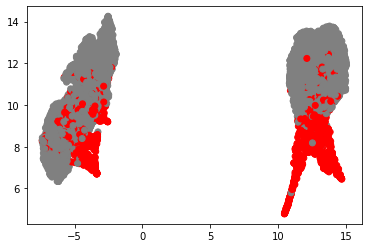

In [53]:
c_clusters = [color[int(y_train[i])] for i in range(len(y_train))]
plt.scatter(x_emb_train[:,0], x_emb_train[:,1], color=c_clusters)

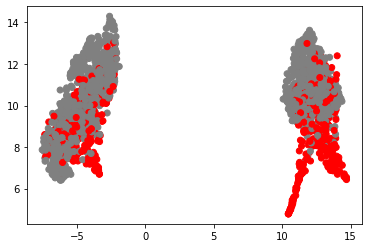

In [54]:
c_clusters = [color[int(y_test[i])] for i in range(len(y_test))]
plt.scatter(x_emb_test[:,0], x_emb_test[:,1], color=c_clusters)

In [55]:
X1, y_pred = model(torch.tensor(X_test).to(device).float(), output="decoded")
print("Test F1")
print(f1_score(np.argmax(y_pred.detach().numpy(), axis=1), y_test))

Test F1
0.6645962732919255
